In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [2]:
#Read Data
ambition=pd.read_pickle('data/temp/ambition.pkl')
credits=pd.read_pickle('data/temp/credits_prices.pkl')
missing_credits=pd.read_pickle('data/temp/missing_credits_prices.pkl').rename(columns={'Quantity Issued':'credit_retired'})

control_var=pd.read_pickle('data/temp/combined_control.pkl')


scope1=pd.read_pickle('data/temp/scope1_total.pkl')
scope2=pd.read_pickle('data/temp/scope2_total.pkl')

emission_overwrite=pd.read_excel('data/company_data/Data.xlsx', sheet_name='emission_overwrite').set_index('CDP_ID')


credits_cumulative=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Credit_no_2018_2023').set_index('CDP_ID')

reporting_years=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Reporting_year').set_index('CDP_ID')




# extract year for which companies report
reporting_years['end_year']=reporting_years['end_date'].dt.year



# Select control variables for correct reporting year
control_var=control_var.set_index('CDP_ID')
control_var['revenue']=np.nan
for i in control_var.index:
    if i in reporting_years.index:
   
        if reporting_years.loc[i,'end_year']==2022:
            control_var.loc[i,'revenue']=control_var.loc[i,'TOTAL_REV_FY2022']
        elif reporting_years.loc[i,'end_year']==2023:
            control_var.loc[i,'revenue']=control_var.loc[i,'TOTAL_REV_FY2023']
control_var=control_var.reset_index()


# Overwritre emisson data where approriate
for i in emission_overwrite.index:
    if emission_overwrite.loc[i, 'scope1_2023']>0:
        scope1.loc[i, 'scope1_2023']=float(emission_overwrite.loc[i, 'scope1_2023'])
    if emission_overwrite.loc[i, 'scope1_2018']>0:
        scope1.loc[i, 'scope1_2018']=float(emission_overwrite.loc[i, 'scope1_2018'])




# sum up money spent on carbon credits for CDP data
credits_id = credits.groupby('Account number')['money_spent'].sum().reset_index()


# sum up money spent on carbon credits for registry data
missing_credits_id = missing_credits.groupby('CDP_ID')['money_spent'].sum().reset_index()

# select rows where no credits are missing
filtered_credits_id = credits_id[~credits_id['Account number'].isin(missing_credits_id['CDP_ID'])]

# Rename the column in missing_credits_id to match credits_id
missing_credits_id.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# combine CDP and registry data
combined_credits = pd.concat([filtered_credits_id, missing_credits_id], ignore_index=True)

# sum money spent for each company
final_credits = combined_credits.groupby('Account number')['money_spent'].sum()

credits_id=final_credits

## Cumulative credits
# Selecting the columns for the specified years
columns = [2018, 2019, 2020, 2021, 2022, 2023]

# get all retired credits for the years 2018-2023
credits_2018_2023= credits_cumulative[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1, skipna=False)
credits_2018_2023.to_pickle('data/temp/credits_2018_2023.pkl')



# Sum number of credits for each company in the CDP data
credits_no = credits.groupby('Account number')['credit_retired'].sum().reset_index()


# Sum number of credits for each company in the registry data
missing_credits_no = missing_credits.groupby('CDP_ID')['credit_retired'].sum().reset_index()

# Select rows where no credits are missing
filtered_credits_no = credits_no[~credits_no['Account number'].isin(missing_credits_no['CDP_ID'])]

# Rename the column in missing_credits_no to match credits_no
missing_credits_no.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# Combine CDP and registry data
combined_credit_number = pd.concat([filtered_credits_no, missing_credits_no], ignore_index=True)

# Sum number of credits for each company
final_credits_number = combined_credit_number.groupby('Account number')['credit_retired'].sum()

credit_number=final_credits_number

#Avianca purchased to not pay colombian carbon tax - set voluntary retirement to 0
credit_number.loc[50174]=0
credits_id.loc[50174]=0


# Save result
credit_number.to_pickle('data/temp/credit_number.pkl')



# build amibotion dataframe
ambition['credit_spent']=credits_id
ambition['credit_spent']=ambition['credit_spent'].fillna(0)
ambition['offset_share']=(100*(credit_number/scope1['scope1_2023']).replace(np.nan, 0))
ambition['credit_number']=credit_number
ambition['credit_number']=ambition['credit_number'].fillna(0)
ambition['credit_2018_2023']=credits_2018_2023


scope1['credit_spent']=credits_id
scope1['credit_spent']=scope1['credit_spent'].fillna(0)
scope1['credit_number']=credit_number
scope1['credit_number']=scope1['credit_number'].fillna(0)
scope1['credit_2018_2023']=credits_2018_2023


In [3]:
scope2[scope2.scope2_2018.isna()]

,company_name,scope2_2023,scope2_2018,scope2_difference
866803,Mercedes-Benz Group AG,1121000.00,NaN,NaN
58656,NFI Group Inc.,18011.00,NaN,NaN
20048,Valero Energy Corporation,5448000.00,NaN,NaN
5767,"EOG Resources, Inc.",391603.00,NaN,NaN
14774,ORLEN S.A.,NaN,NaN,NaN
14802,Pioneer Natural Resources,482284.00,NaN,NaN
10150,Kinder Morgan Inc.,3100000.00,NaN,NaN
21135,KOÇ HOLDİNG A.Ş.,NaN,NaN,NaN
20705,"The Williams Companies, Inc.",1777329.71,NaN,NaN
11043,PJSC Lukoil,5685287.00,NaN,NaN


In [4]:
scope2

,company_name,scope2_2023,scope2_2018,scope2_difference
19290,Toyota Motor Corporation,3810000.000,5265425.00,0.723588
20309,Volkswagen AG,4650011.000,5901889.00,0.787885
866803,Mercedes-Benz Group AG,1121000.000,NaN,NaN
1932,BMW AG,1187339.000,1572432.00,0.755097
7164,General Motors Company,2996074.000,4572734.00,0.655204
...,...,...,...,...
59365,Chorus Aviation,3053.000,NaN,NaN
10289,Korean Air Lines Co Ltd,43301.000,67207.00,0.644293
9703,Japan Airlines Corporation,54331.000,67000.00,0.810910
50174,Avianca Group,5001.200,3939.81,1.269401


### Ambition with share of intensity Target



In [5]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number']]))
model_1 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_1).fit()

# 2. Credit number + weighted ambition
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intensity_coverage']]))
model_2 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_2).fit()

# 3. Credit number + weighted ambition + revenue
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intensity_coverage', 'revenue']]))
model_3 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_3).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intensity_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_4 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_4).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_5 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intensity_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_5 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_5).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4, model_5], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())


\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Model 1     & Model 2     & Model 3     & Model 4     & Model 5      \\
\hline
const          & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535***  \\
               & (0.6446)    & (0.6138)    & (0.6030)    & (0.5380)    & (0.4970)     \\
x1             & 1.0834*     & 0.4952      & 0.2431      & 0.3050      & 0.1671       \\
               & (0.6446)    & (0.6414)    & (0.6423)    & (0.5840)    & (0.5437)     \\
x2             &             & 2.0247***   & 1.9380***   & 0.3340      & 0.2152       \\
               &             & (0.6414)    & (0.6316)    & (0.6628)    & (0.6447)     \\
x3             &             &             & 1.2555**    & 2.0524***   & 1.3419**     \\
               &             &             & (0.6197)    & (0.6460)    & (0.6242)     \\
x4             &             &             &             & -0.0506     & 0.1734       \\
               &       

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_46992/3667665798.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='red')


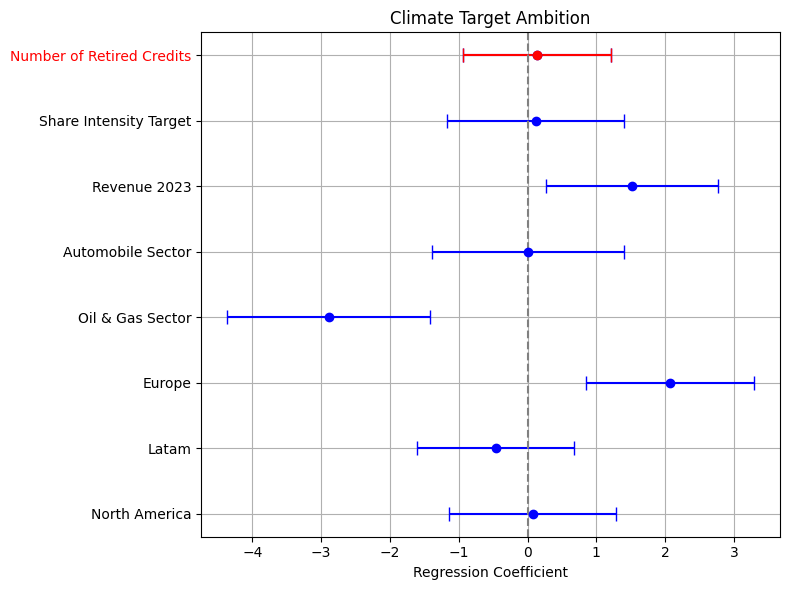

In [6]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'TOTAL_REV_FY2023', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_number', 'weighted_intensity_coverage', 'TOTAL_REV_FY2023', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_int = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()



import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model_credit_number'

# Extract coefficients and confidence intervals
coefficients = model_credit_number_int.params.drop('const')
conf = model_credit_number_int.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'weighted_intensity_coverage', 'TOTAL_REV_FY2023', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['weighted_ambition'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latam', 'Europe', 'Oil & Gas Sector', 'Automobile Sector', 'Revenue 2023', 'Share Intensity Target', 'Number of Retired Credits','const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))

# Plot all the points and error bars
bars = plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5, color='blue')

position=len(conf)-2
# Change the color of the uppermost point and error bar
plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='red')

# Highlight the uppermost ylabel
plt.gca().get_yticklabels()[position].set_color('red')

plt.axvline(0, color='grey', linestyle='--')
plt.title('Climate Target Ambition')
plt.xlabel('Regression Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

### Spending on carbon credits and ambition

In [7]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_spent']]))
model_1 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_1).fit()

# 2. Credit number + weighted ambition
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_spent', 'weighted_intermediate_coverage']]))
model_2 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_2).fit()

# 3. Credit number + weighted ambition + revenue
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_spent', 'weighted_intermediate_coverage', 'revenue']]))
model_3 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_3).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_spent', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_4 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_4).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_5 = sm.add_constant(scaler.fit_transform(regression_df[['credit_spent', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_5 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_5).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4, model_5], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Model 1     & Model 2     & Model 3     & Model 4     & Model 5      \\
\hline
const          & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535***  \\
               & (0.6437)    & (0.5790)    & (0.5730)    & (0.5179)    & (0.4928)     \\
x1             & 1.1305*     & 0.4324      & 0.1997      & 0.2298      & 0.1322       \\
               & (0.6437)    & (0.5983)    & (0.6081)    & (0.5626)    & (0.5392)     \\
x2             &             & 2.7748***   & 2.6439***   & 1.6120**    & 0.8020       \\
               &             & (0.5983)    & (0.5972)    & (0.6183)    & (0.6478)     \\
x3             &             &             & 1.0047*     & 1.5462**    & 1.2029*      \\
               &             &             & (0.5993)    & (0.6478)    & (0.6275)     \\
x4             &             &             &             & 0.4138      & 0.3328       \\
               &       

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     9.464
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           4.13e-09
Time:                        16:46:38   Log-Likelihood:                -257.72
No. Observations:                  89   AIC:                             533.4
Df Residuals:                      80   BIC:                             555.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

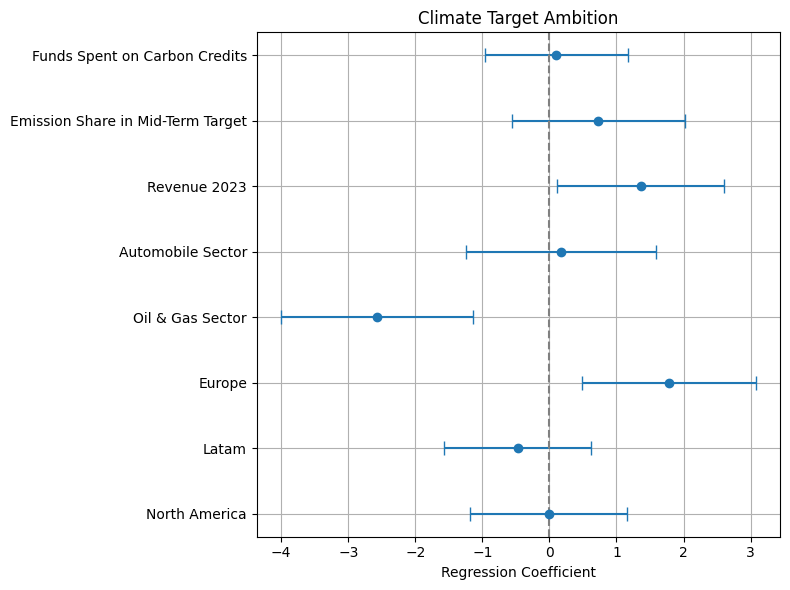

In [8]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'TOTAL_REV_FY2023', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_spent', 'weighted_intermediate_coverage', 'TOTAL_REV_FY2023', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_money_spent = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_money_spent.summary())



import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model'

# Extract coefficients and confidence intervals
coefficients = model_money_spent.params.drop('const')
conf = model_money_spent.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'weighted_intermediate_coverage', 'TOTAL_REV_FY2023', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['weighted_ambition'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latam', 'Europe', 'Oil & Gas Sector', 'Automobile Sector', 'Revenue 2023', 'Emission Share in Mid-Term Target', 'Funds Spent on Carbon Credits','const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Climate Target Ambition')
#plt.ylabel('Predictors')
plt.xlabel('Regression Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

## Cumulative number of credits vs. ambition

In [9]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]
regression_df=regression_df[regression_df['credit_2018_2023'].notna()]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023']]))
model_1 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_1).fit()

# 2. Credit number + weighted ambition
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'weighted_intermediate_coverage']]))
model_2 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_2).fit()

# 3. Credit number + weighted ambition + revenue
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'weighted_intermediate_coverage', 'revenue']]))
model_3 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_3).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_4 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_4).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_5 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_5 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_5).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4, model_5], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Model 1    & Model 2    & Model 3    & Model 4    & Model 5     \\
\hline
const          & -9.5690*** & -9.5690*** & -9.5690*** & -9.5690*** & -9.5690***  \\
               & (0.7162)   & (0.6510)   & (0.6490)   & (0.5694)   & (0.5416)    \\
x1             & 0.9531     & 0.4193     & 0.3364     & 0.2688     & 0.3782      \\
               & (0.7162)   & (0.6647)   & (0.6662)   & (0.5976)   & (0.5740)    \\
x2             &            & 2.6513***  & 2.5323***  & 1.2826*    & 0.4321      \\
               &            & (0.6647)   & (0.6700)   & (0.6874)   & (0.7213)    \\
x3             &            &            & 0.7933     & 1.3636*    & 0.8591      \\
               &            &            & (0.6623)   & (0.6898)   & (0.6767)    \\
x4             &            &            &            & 0.5821     & 0.7590      \\
               &            &            &            & (0.7956)   & (0.8

In [10]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'TOTAL_REV_FY2023', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df=regression_df[regression_df['credit_2018_2023'].notna()]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_2018_2023', 'weighted_intensity_coverage', 'TOTAL_REV_FY2023', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_cumulative = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number_cumulative.summary())

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     8.122
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.67e-07
Time:                        16:46:38   Log-Likelihood:                -210.12
No. Observations:                  73   AIC:                             438.2
Df Residuals:                      64   BIC:                             458.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Target Coverage
Logit Regression of number of carbon credits retired in 2022 on probability of having an intermediate target that covers more than 50% of scope 1,2 & 3 emissions


In [11]:
#add dummy variable for target covering more than 50% of emissions
ambition['intermediate_complete'] = ambition['weighted_intermediate_coverage'].apply(lambda x: 1 if x > 50 else 0)

In [12]:
import statsmodels.api as sm

regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID']!=11043]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Selecting the predictors
predictors = ['credit_number', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = sm.add_constant(scaler.fit_transform(regression_df[predictors]))


# Fitting the regression model
model_prob_target = sm.Logit(regression_df['intermediate_complete'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_prob_target.summary())

Optimization terminated successfully.
         Current function value: 0.398916
         Iterations 11
                             Logit Regression Results                            
Dep. Variable:     intermediate_complete   No. Observations:                   89
Model:                             Logit   Df Residuals:                       81
Method:                              MLE   Df Model:                            7
Date:                   Tue, 10 Jun 2025   Pseudo R-squ.:                  0.4219
Time:                           16:46:38   Log-Likelihood:                -35.504
converged:                          True   LL-Null:                       -61.415
Covariance Type:               nonrobust   LLR p-value:                 6.330e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8513      1.260      0.676      0.499      -1.618       3.321
x1  

In [13]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number']]))
model_1 = sm.Logit(regression_df['intermediate_complete'].reset_index(drop=True), X_1).fit()


# 3. Credit number + weighted ambition + revenue
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number',  'revenue']]))
model_2 = sm.Logit(regression_df['intermediate_complete'].reset_index(drop=True), X_2).fit()


# 4. Credit number + weighted ambition + revenue + sectors
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number',  'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_3 = sm.Logit(regression_df['intermediate_complete'].reset_index(drop=True), X_3).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_4 = sm.Logit(regression_df['intermediate_complete'].reset_index(drop=True), X_4).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                                 info_dict={'Pseudo R-squared': lambda x: f"{x.prsquared:.4f}" })

# Printing the results in LaTeX format
print(regression_results.as_latex())



Optimization terminated successfully.
         Current function value: 0.624651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.623720
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.466984
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.398916
         Iterations 11
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                 & Model 1  & Model 2  & Model 3    & Model 4     \\
\hline
const            & 1.6112   & 1.5685   & 1.7338     & 0.8513      \\
                 & (1.0304) & (1.0556) & (1.4334)   & (1.2600)    \\
x1               & 7.6295   & 7.3327   & 7.6870     & 2.4448      \\
                 & (4.7060) & (4.8493) & (6.5916)   & (5.7514)    \\
x2               &          & 0.1254   & 0.8539*    & 0.8499*     \\
                 &          & (0.3092) & (0.4458)   & (0.4670)    \\
x3               & 

In [14]:
regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]

,credit_number,weighted_intermediate_coverage,revenue,Sector_Automobile,Sector_O&G,Continent_Europe,Continent_Latam,Continent_North America
0,5796283.0,88.044786,3.813140e+08,False,True,True,False,False
1,640000.0,73.231051,2.633100e+08,False,True,True,False,False
2,2272807.0,73.231051,2.390670e+08,False,True,True,False,False
3,40649.0,11.369072,1.490040e+08,False,True,True,False,False
4,0.0,11.369072,1.244204e+08,False,True,False,True,False
...,...,...,...,...,...,...,...,...
85,0.0,0.000000,1.226873e+06,False,False,False,False,True
86,0.0,73.532728,1.094172e+07,False,False,False,False,False
87,0.0,73.532728,1.017651e+07,False,False,False,False,False
88,0.0,73.210284,4.047856e+06,False,False,False,True,False


# Offsetting vs. Emission 

### Scope 1 vs. cumulative credits 2018-2023

In [15]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent','Sector']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df=regression_df[regression_df['credit_2018_2023'].notna()]
drop_list=[11043, 866803]
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_2018_2023',  'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_cumulative = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number_cumulative.summary())

                            OLS Regression Results                            
Dep. Variable:      scope1_difference   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.7997
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.591
Time:                        16:46:38   Log-Likelihood:                -103.45
No. Observations:                  65   AIC:                             222.9
Df Residuals:                      57   BIC:                             240.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [16]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent','Sector']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df['credit_binary']=regression_df['credit_2018_2023'].apply(lambda x: 1 if x>100000 else 0)

regression_df=regression_df[regression_df['credit_2018_2023'].notna()]
drop_list=[11043, 866803]
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_binary',  'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_cumulative = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number_cumulative.summary())

                            OLS Regression Results                            
Dep. Variable:      scope1_difference   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     2.099
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0582
Time:                        16:46:39   Log-Likelihood:                -99.038
No. Observations:                  65   AIC:                             214.1
Df Residuals:                      57   BIC:                             231.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [17]:
regression_df[regression_df['credit_2018_2023']>100000]

,CDP_ID,company_name,scope1_2023,scope1_2018,scope1_difference,credit_spent,credit_number,credit_2018_2023,revenue,EBITDA_FY2023,TOTAL_ASSETS_FY2023,credit_binary,Sector_Automobile,Sector_O&G,Continent_Europe,Continent_Latam,Continent_North America
1,20309,Volkswagen AG,4.461403e+06,4297748.00,1.038079,2.682752e+07,4584163.00,11977499.27,2.939818e+08,37620657.979339,663576876.31259,1,True,False,True,False,False
3,1932,BMW AG,6.940570e+05,625072.00,1.110363,7.083739e+06,851528.00,1716158.00,1.502410e+08,26090909.381692,277318448.104344,1,True,False,True,False,False
23,16012,Shell PLC,5.100000e+07,73000000.00,0.698630,5.632177e+07,5796283.00,12173140.00,3.813140e+08,46218000,406270000,1,False,True,True,False,False
24,19257,TotalEnergies,3.722000e+07,36200000.00,1.028177,6.489600e+06,640000.00,640000.00,2.633100e+08,43909000,283654000,1,False,True,True,False,False
26,23132,Equinor,1.136583e+07,15391778.00,0.738435,4.121809e+05,40649.00,280104.00,1.490040e+08,44280000,143580000,1,False,True,True,False,False
28,5634,Eni SpA,3.939415e+07,42515724.00,0.926578,3.076704e+07,3034225.00,8474151.00,1.407900e+08,18087894.69052,157627942.964519,1,False,True,True,False,False
41,22341,Ecopetrol S.A.,1.315948e+07,10251000.00,1.283726,2.043984e+06,424055.00,1561891.00,3.776283e+07,13630817.537718,72865407.330924,1,False,True,False,True,False
44,13870,OMV AG,1.168902e+07,11148973.00,1.048440,1.094596e+06,263124.14,333178.14,6.387955e+07,7632064.145351,55999778.932243,1,False,True,True,False,False
50,9134,Inpex Corporation,6.338586e+06,584309.00,10.848003,1.271960e+06,250791.00,788620.00,1.779392e+07,10813795.309795,47810587.250465,1,False,True,False,False,False
51,849766,Petroliam Nasional Berhad (PETRONAS),4.762000e+07,55878500.00,0.852206,1.584294e+05,38084.00,109323.00,7.577521e+07,31193108.471307,168566975.476839,1,False,True,False,False,False


In [18]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
# Merging the dataframes
regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent','Sector']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df=regression_df[regression_df['credit_2018_2023'].notna()]
drop_list=[11043, 866803]
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023']]))
model_1 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_1).fit()


# 3. Credit number + weighted ambition + revenue
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'revenue']]))
model_2 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_2).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_3 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_3).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_2018_2023', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_4 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_4).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
               & Model 1   & Model 2   & Model 3   & Model 4    \\
\hline
const          & 1.1050*** & 1.1050*** & 1.1050*** & 1.1050***  \\
               & (0.1568)  & (0.1572)  & (0.1563)  & (0.1574)   \\
x1             & -0.0343   & -0.0165   & 0.0403    & 0.0534     \\
               & (0.1568)  & (0.1585)  & (0.1646)  & (0.1676)   \\
x2             &           & -0.1363   & -0.2183   & -0.1637    \\
               &           & (0.1585)  & (0.1736)  & (0.1877)   \\
x3             &           &           & 0.1072    & -0.0183    \\
               &           &           & (0.2129)  & (0.2329)   \\
x4             &           &           & 0.3231    & 0.2835     \\
               &           &           & (0.2144)  & (0.2227)   \\
x5             &           &           &           & -0.2306    \\
               &           &           &           & (0.2006)   \\
x6             &           &           &   

In [19]:
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:      scope1_difference   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8768
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.483
Time:                        16:46:39   Log-Likelihood:                -104.64
No. Observations:                  65   AIC:                             219.3
Df Residuals:                      60   BIC:                             230.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1050      0.156      7.071      0.0

## Scope 1 & 2 emissions

In [20]:
emissions=scope1[['scope1_2023','scope1_2018']]
emissions[['scope2_2023','scope2_2018']]=scope2[['scope2_2023','scope2_2018']]

emissions=emissions[emissions['scope2_2018'].notna()]
emissions=emissions[emissions['scope2_2023'].notna()]

emissions['scope12_2023']=emissions['scope1_2023']+emissions['scope2_2023']
emissions['scope12_2018']=emissions['scope1_2018']+emissions['scope2_2018']

emissions['scope12_difference']=emissions['scope12_2023']/emissions['scope12_2018']
emissions['credit_number']=credit_number.replace(np.nan, 0)

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_46992/3822802260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions[['scope2_2023','scope2_2018']]=scope2[['scope2_2023','scope2_2018']]
/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_46992/3822802260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions[['scope2_2023','scope2_2018']]=scope2[['scope2_2023','scope2_2018']]


In [21]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(emissions.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent','Sector']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df=regression_df[regression_df['credit_number'].notna()]
drop_list=[11043, 866803]
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]


# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Selecting the predictors
predictors = ['credit_number',  'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_cumulative = sm.OLS(regression_df['scope12_difference'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number_cumulative.summary())

                            OLS Regression Results                            
Dep. Variable:     scope12_difference   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.8061
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.594
Time:                        16:46:39   Log-Likelihood:                -48.601
No. Observations:                  25   AIC:                             113.2
Df Residuals:                      17   BIC:                             123.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [22]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col


# Merging the dataframes
regression_df = pd.merge(emissions.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent','Sector']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df=regression_df[regression_df['credit_number'].notna()]
drop_list=[11043, 866803]
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]


# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Standardizing the predictors
scaler = StandardScaler()

# Stepwise regression: defining each stage of the regression


# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number']]))
model_1 = sm.OLS(regression_df['scope12_difference'].reset_index(drop=True), X_1).fit()


# 3. Credit number + weighted ambition + revenue
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue']]))
model_2 = sm.OLS(regression_df['scope12_difference'].reset_index(drop=True), X_2).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_3 = sm.OLS(regression_df['scope12_difference'].reset_index(drop=True), X_3).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_4 = sm.OLS(regression_df['scope12_difference'].reset_index(drop=True), X_4).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
               & Model 1   & Model 2   & Model 3   & Model 4    \\
\hline
const          & 1.3024*** & 1.3024*** & 1.3024*** & 1.3024***  \\
               & (0.4055)  & (0.4098)  & (0.3979)  & (0.4100)   \\
x1             & -0.1599   & -0.0812   & 0.1452    & 0.2649     \\
               & (0.4055)  & (0.4241)  & (0.4300)  & (0.5319)   \\
x2             &           & -0.3053   & -0.9350   & -0.8011    \\
               &           & (0.4241)  & (0.5630)  & (0.6917)   \\
x3             &           &           & 0.4970    & 0.5238     \\
               &           &           & (0.5104)  & (0.5268)   \\
x4             &           &           & 0.9626*   & 0.9611     \\
               &           &           & (0.5270)  & (0.5538)   \\
x5             &           &           &           & -0.6238    \\
               &           &           &           & (0.5574)   \\
x6             &           &           &   